<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/ConformalPrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicação de LSTM e Conformal Prediction
Carlos Monteiro


In [2]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from math import pi



from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from datetime import datetime, timedelta

!pip install --quiet optuna

import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.0 MB/s eta 0:00:00


# 1. Preparação dos dados

## 1.1 Gerar Dados

In [132]:

ticker = "PETR4.SA"
end_date = datetime.today()
start_date = end_date - timedelta(days=20*365)


df = yf.download(
    ticker,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1d",
    auto_adjust=False,   # Mantém OHLC originais
    progress=False
)

df


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2006-01-12,4.206233,21.325001,21.795000,20.950001,21.145000,16237800
2006-01-13,4.201303,21.299999,21.620001,21.080000,21.424999,7932600
2006-01-16,4.285132,21.725000,21.895000,21.305000,21.305000,10409800
2006-01-17,4.221026,21.400000,22.004999,21.125000,21.475000,12339600
2006-01-18,4.179606,21.190001,21.325001,20.860001,21.100000,9901600
...,...,...,...,...,...,...
2025-12-29,30.730000,30.730000,30.809999,30.520000,30.559999,20588100
2025-12-30,30.820000,30.820000,30.959999,30.650000,30.799999,16880600


In [133]:
df.columns = [col[0] for col in df.columns]
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [134]:
df = df.drop(columns=['Adj Close'])
df = df[df['Volume'] != 0]

In [135]:
#df['y'] = (df['Close'].diff(periods=-1))*-1
df['y'] = df['Close'].shift(0)
display(df.head())

,Close,High,Low,Open,Volume,y
Date,,,,,,
2006-01-12,21.325001,21.795000,20.950001,21.145000,16237800,21.325001
2006-01-13,21.299999,21.620001,21.080000,21.424999,7932600,21.299999
2006-01-16,21.725000,21.895000,21.305000,21.305000,10409800,21.725000
2006-01-17,21.400000,22.004999,21.125000,21.475000,12339600,21.400000
2006-01-18,21.190001,21.325001,20.860001,21.100000,9901600,21.190001


In [136]:
print(df.isnull().sum())
df.dropna(inplace=True)

Close     0
High      0
Low       0
Open      0
Volume    0
y         0
dtype: int64


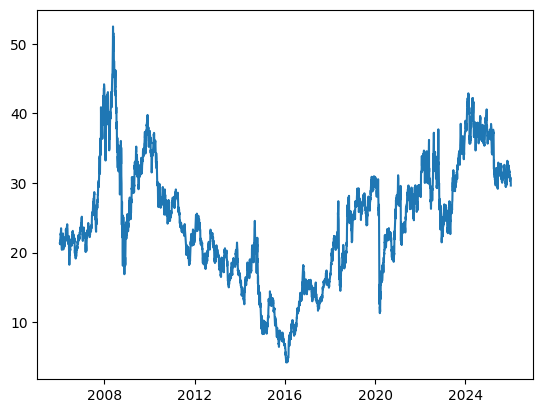

In [137]:
plt.plot(df['y'])

## 1.2 Scaling and Deframing

In [138]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,Close,High,Low,Open,Volume,y
0,0.354482,0.354685,0.351871,0.350248,0.012138,0.354482
1,0.353964,0.351144,0.354589,0.356036,0.005922,0.353964
2,0.362761,0.356709,0.359293,0.353555,0.007776,0.362761
3,0.356034,0.358935,0.355530,0.357069,0.009220,0.356034
4,0.351687,0.345173,0.349990,0.349318,0.007395,0.351687


Features shape: (1, 4899, 5), Targets shape: (1, 4899, 1)


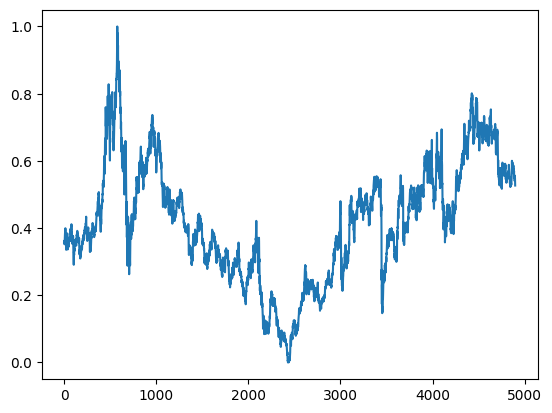

In [139]:
columns_features = [col for col in df.columns if not col.startswith('y')]
n_features = len(columns_features)
n_samples = len(df)

X = df_scaled[columns_features].values.astype(np.float32).reshape(1, -1, n_features)
y = df_scaled['y'].values.astype(np.float32).reshape(1, -1, 1)

#X = df[columns_features].values.astype(np.float32).reshape(1, -1, n_features)
#y = df['y'].values.astype(np.float32).reshape(1, -1, 1)




print(f"Features shape: {X.shape}, Targets shape: {y.shape}")
plt.plot(y[0,:,0])



## 1.3 Criar janela de entrada e de previsão em um dataset

In [140]:
class WindowedTS(Dataset):
    """
    PyTorch Dataset for sliding window forecasting.

    CONCEPT: Long time series → many overlapping windows

    Example with history=3, forecast=2:
      Series: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      Window 1: history=[0,1,2], forecast=[3,4]
      Window 2: history=[1,2,3], forecast=[4,5]
      Window 3: history=[2,3,4], forecast=[5,6]
      ... and so on

    This creates many training examples from a single long series!

    Returns (for each window):
        Xw: Historical features [history_len, n_features]
        y_in: Decoder inputs (teacher forcing) [forecast_len, 1]
              First token = 0 (start token)
              Remaining tokens = shifted ground-truth targets
        y_true: Ground-truth future targets [forecast_len, 1]

    Args:
        X: All features [n_series, series_length, n_features]
        y: All targets [n_series, series_length, 1]
        T_x: History length (how much past to use)
        T_y: Forecast horizon (how far ahead to predict)
    """
    def __init__(self, X, y, T_x: int, T_y: int):
        self.X = X
        self.y = y
        self.T_x = T_x  # History window size
        self.T_y = T_y  # Forecast horizon
        self.length = X.shape[1]

        # BUILD INDEX: list of all valid (series_id, start_time) pairs
        self.index = []
        for i in range(X.shape[0]):  # For each series
            # For each valid starting position
            for t in range(self.length - (T_x + T_y) + 1):
                self.index.append((i, t))

        # Total windows = n_series * (series_length - T_x - T_y + 1)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """
        Extract one training window.

        Returns:
            Xw: Historical window [T_x, n_features]
            y_in: Decoder inputs [T_y, 1] (shifted targets with start token)
            y_future: Ground-truth targets [T_y, 1]
        """
        i, t = self.index[idx]  # Which series, which starting time

        # EXTRACT HISTORY
        Xw = self.X[i, t:t+self.T_x, :].copy()  # [T_x, n_features]

        # EXTRACT FUTURE TARGETS
        y_future = self.y[i, t+self.T_x:t+self.T_x+self.T_y, :].copy()  # [T_y, 1]

        # CREATE TEACHER FORCING INPUTS (shifted right by 1)
        y_in = np.zeros((self.T_y, 1), dtype=np.float32)
        y_in[1:, 0] = y_future[:-1, 0]  # Shift: positions 1..T_y get targets 0..T_y-1
        # y_in[0] = 0 (start token)

        return torch.from_numpy(Xw), torch.from_numpy(y_in), torch.from_numpy(y_future)

In [141]:
T_X = 32
T_Y = 8
ds = WindowedTS(X, y, T_x=T_X, T_y=T_Y)
print(f"Total windows: {len(ds)} (history={T_X}, forecast={T_Y})")

Total windows: 4860 (history=32, forecast=8)


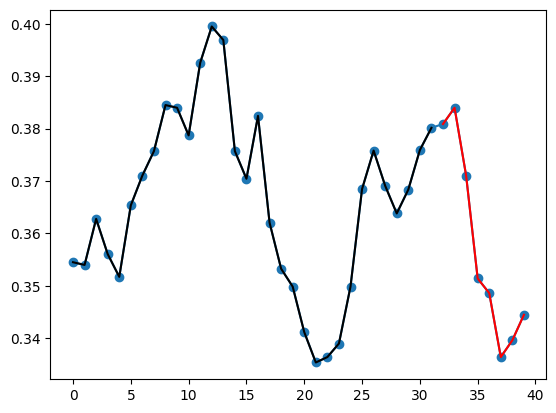

In [146]:
history_features, decoder_inputs, future_targets = ds[0]

n_history = len(history_features[:, 0].numpy())
n_future = len(future_targets.numpy().flatten())

#cumulative_future = np.cumsum(future_targets.numpy().flatten()) + history_features[-1, 0].numpy()

plt.plot(range(n_history + n_future), df_scaled.iloc[:n_history + n_future,0], marker='o')
plt.plot(range(n_history), history_features[:, 0].numpy(), color='k')
plt.plot(range(n_history, n_history + n_future), future_targets.numpy().flatten(), color='r')
#plt.plot(range(n_history, n_history + n_future), cumulative_future, color='g')

#plt.axis([0,50, 20, 25])


In [148]:
for i in range(n_history + n_future):
  num1 = df_scaled.iloc[i,0]
  if i < n_history:
    num2 = history_features[i, 0].numpy()
    print(f'{i:2.0f} | {num1:.4f} | {num2:.4f} | {num1-num2:.4f}')
  else:
    num2 = future_targets[i - n_history].numpy()[0]
    if i == n_history:
      print(f'-------------------------------------')
    print(f'{i} | {num1:.4f} | {num2:.4f} | {num1-num2:.4f}')


 0 | 0.3545 | 0.3545 | -0.0000
 1 | 0.3540 | 0.3540 | 0.0000
 2 | 0.3628 | 0.3628 | 0.0000
 3 | 0.3560 | 0.3560 | 0.0000
 4 | 0.3517 | 0.3517 | 0.0000
 5 | 0.3653 | 0.3653 | -0.0000
 6 | 0.3710 | 0.3710 | -0.0000
 7 | 0.3757 | 0.3757 | 0.0000
 8 | 0.3845 | 0.3845 | -0.0000
 9 | 0.3840 | 0.3840 | 0.0000
10 | 0.3787 | 0.3787 | -0.0000
11 | 0.3926 | 0.3926 | 0.0000
12 | 0.3995 | 0.3995 | -0.0000
13 | 0.3969 | 0.3969 | 0.0000
14 | 0.3757 | 0.3757 | 0.0000
15 | 0.3704 | 0.3704 | -0.0000
16 | 0.3824 | 0.3824 | 0.0000
17 | 0.3620 | 0.3620 | -0.0000
18 | 0.3532 | 0.3532 | -0.0000
19 | 0.3498 | 0.3498 | 0.0000
20 | 0.3411 | 0.3411 | -0.0000
21 | 0.3353 | 0.3353 | 0.0000
22 | 0.3364 | 0.3364 | 0.0000
23 | 0.3390 | 0.3390 | -0.0000
24 | 0.3498 | 0.3498 | 0.0000
25 | 0.3685 | 0.3685 | 0.0000
26 | 0.3758 | 0.3758 | -0.0000
27 | 0.3691 | 0.3691 | -0.0000
28 | 0.3638 | 0.3638 | -0.0000
29 | 0.3684 | 0.3684 | 0.0000
30 | 0.3759 | 0.3759 | 0.0000
31 | 0.3801 | 0.3801 | -0.0000
-------------------------

## 1.7 Separa em treino, validação e test e Cria dataloader

In [158]:
BATCH = 64

val_idx = int(len(ds)*0.6)
test_idx = int(len(ds)*0.8)

train_ds = Subset(ds, list(range(val_idx)))
val_ds = Subset(ds, list(range(val_idx, test_idx)))
test_ds = Subset(ds, list(range(test_idx, len(ds))))

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, drop_last=False)

# 2. Aplicação dos modelos

### Pré-seting

In [152]:
# =============================================================================
#                       0) RUNTIME / DEVICE SETTINGS
# =============================================================================
# PEDAGOGICAL NOTE: Modern deep learning leverages GPU acceleration.
# This section configures PyTorch to use CUDA (NVIDIA GPUs) if available.

# Automatically detect and use GPU if available, otherwise fall back to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE == "cuda":
    # Enable cuDNN autotuner: finds the fastest convolution algorithms for your hardware
    # (Not critical for Transformers, but good practice for CNNs)
    torch.backends.cudnn.benchmark = True

    # Use TensorFloat-32 (TF32) for faster matrix multiplications on Ampere+ GPUs
    # TF32 trades a tiny bit of precision for ~8x speed improvement
    try:
        torch.set_float32_matmul_precision("high")  # options: "highest", "high", "medium"
    except Exception:
        pass  # Older PyTorch versions don't support this

# MIXED PRECISION TRAINING SETUP
# Why? Training in 16-bit (half precision) is ~2x faster and uses less memory
# than 32-bit (full precision), with minimal accuracy loss.
USE_AMP = (DEVICE == "cuda")                                 # Enable AMP only on GPU
USE_BF16 = USE_AMP and torch.cuda.is_bf16_supported()        # BFloat16 is more stable than Float16
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16    # Choose precision for autocast
SCALER_ENABLED = USE_AMP and (not USE_BF16)                  # GradScaler only needed for fp16

# REPRODUCIBILITY: Set random seeds for consistent results across runs
# Important for teaching: students can reproduce exact results
torch.manual_seed(7)
np.random.seed(7)

## 2.1 LSTM

### Definição da função

In [160]:
class TS_LSTM(nn.Module):
    def __init__(self, input_size=30, step_ahead=10, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, step_ahead)
        self.to(DEVICE)
        self.step_ahead = step_ahead

        self.history_val_loss = []
        self.history_train_loss = []
        self.history_epoch_loss = []


    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(batch_size, self.step_ahead, 1)

    def fit(self, train_loader, n_epochs=20, lr=0.001, val_loader=None, verbose=1, history=0):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        for epoch in range(n_epochs):
          epoch_loss = self.fit_epoch(train_loader)
          if history:
            self.history_epoch_loss.append(epoch_loss)

            train_loss = self.evaluate(train_loader)
            self.history_train_loss.append(train_loss)

            if val_loader is not None:
              val_loss = self.evaluate(val_loader)
              self.history_val_loss.append(val_loss)
              if verbose:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}, Train: {train_loss:.6f}, Val: {val_loss:.6f}")
            else:
              if verbose:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}, Train: {train_loss:.6f}")

          else:
            if verbose:
              print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

        if not history:
          if val_loader is not None:
            val_loss = self.evaluate(val_loader)
            self.history_val_loss.append(val_loss)
          else:
            train_loss = self.evaluate(train_loader)
            self.history_train_loss.append(train_loss)


    def fit_epoch(self, loader):
        epoch_loss = 0.0
        self.train()
        for X_batch, _, y_batch in loader:
            self.optimizer.zero_grad()
            y_pred = self(X_batch.to(DEVICE))
            loss = self.loss_fn(y_pred.squeeze(), y_batch.squeeze().to(DEVICE))
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(loader.dataset)
        return epoch_loss

    def evaluate(self, test_loader):
        DEVICE = next(self.parameters()).device
        self.eval()  # Set to evaluation mode

        with torch.no_grad():
            # Get one batch from validation set
            Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

            # Use only first sample for visualization
            Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
            ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

            # Generate forecast
            pred = self(Xb).float()

        # Convert to numpy for plotting
        gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
        pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

        # Compute error metrics
        mse = np.mean((pr - gt) ** 2)    # Root Mean Squared Error

        return mse


    def predict(self, X):
        DEVICE = next(self.parameters()).device
        self.eval()  # Set to evaluation mode

        with torch.no_grad():
            # Use only first sample for visualization
            Xb = X.to(DEVICE).float()      # [1, T_x, features]

            # Generate forecast
            pred = self(Xb).float()

        # Convert to numpy for plotting
        pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

        return pr

### Otimização da taxa de aprendizado

Fixa-se todos os outros parametros e varre-se a taxa de aprendizado

In [156]:
model_list = []
lr_list = 10.0**np.arange(-8, -2, 1)

for idx, lr in enumerate(lr_list):
  print(f'Modelo: {idx+1}/{len(lr_list)}')
  model_list.append(TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=64, num_layers=2))
  model_list[-1].fit(train_loader, n_epochs=100, lr=lr, val_loader=val_loader, verbose=0, history=1)

Modelo: 1/6
Modelo: 2/6
Modelo: 3/6
Modelo: 4/6
Modelo: 5/6
Modelo: 6/6


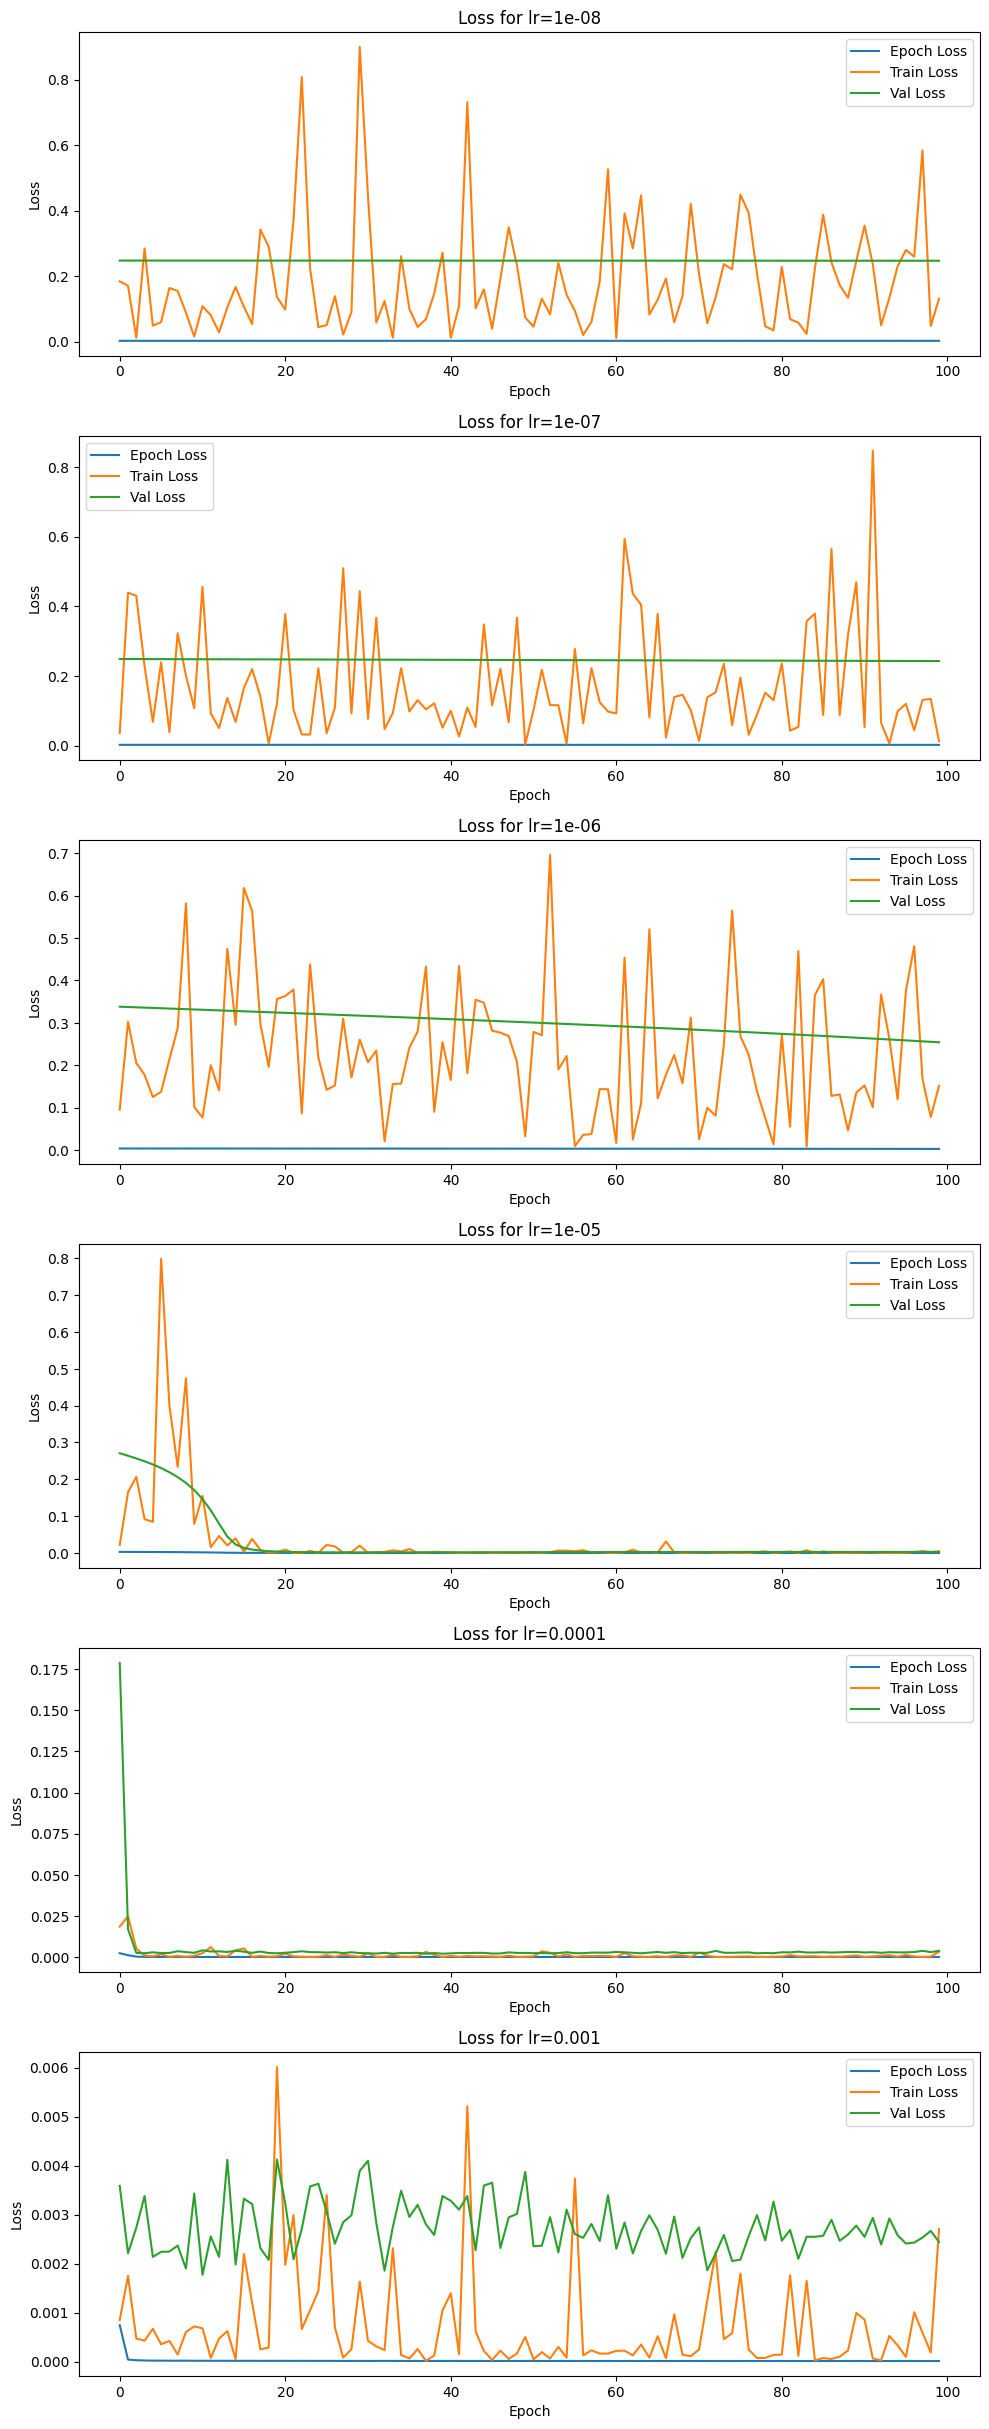

In [157]:
plt.figure(figsize=(10, (len(model_list)+1)*4))
for idx, model in enumerate(model_list):
  plt.subplot(len(model_list)+1, 1, idx+1)

  plt.plot(model.history_epoch_loss, label='Epoch Loss')
  plt.plot(model.history_train_loss, label='Train Loss')
  plt.plot(model.history_val_loss, label='Val Loss')

  plt.title(f'Loss for lr={lr_list[idx]}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plt.tight_layout()
plt.show()

### Otimização dos hiperparâmetros pelo Optuna

In [ ]:
import optuna


def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 8, 256)
    num_layers = trial.suggest_int("num_layers", 1, 30)


    model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=hidden_size, num_layers=num_layers)
    model_lstm.fit(train_loader, n_epochs=35, lr=0.00001, val_loader=val_loader, verbose=0)


    return model_lstm.history_val_loss[-1]


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2026-01-07 02:02:51,043] A new study created in memory with name: no-name-fa4251da-b469-4b15-a685-020deb7fb329
[I 2026-01-07 02:03:08,212] Trial 0 finished with value: 0.014464592561125755 and parameters: {'hidden_size': 90, 'num_layers': 15}. Best is trial 0 with value: 0.014464592561125755.
[I 2026-01-07 02:03:57,359] Trial 1 finished with value: 0.005269771441817284 and parameters: {'hidden_size': 206, 'num_layers': 14}. Best is trial 1 with value: 0.005269771441817284.
[I 2026-01-07 02:04:19,476] Trial 2 finished with value: 0.004114143550395966 and parameters: {'hidden_size': 254, 'num_layers': 5}. Best is trial 2 with value: 0.004114143550395966.
[I 2026-01-07 02:05:30,454] Trial 3 finished with value: 0.0054009221494197845 and parameters: {'hidden_size': 154, 'num_layers': 12}. Best is trial 2 with value: 0.004114143550395966.
[I 2026-01-07 02:05:47,097] Trial 4 finished with value: 0.005978344939649105 and parameters: {'hidden_size': 127, 'num_layers': 9}. Best is trial 2 wi

### Otimização dos hiperparâmetros por Grade

Primeira Grade

In [82]:
hidden_size_list = 2.0**np.arange(1, 8, 1)
num_layers_list = np.arange(1, 10, 3)

rms_list = []

for hidden_size in hidden_size_list:
  aux_list = []
  for num_layers in num_layers_list:
    print(f'Hidden Size {hidden_size} - Num Layer {num_layers}')
    model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=int(hidden_size), num_layers=num_layers)
    model_lstm.fit(train_loader, n_epochs=35, lr=0.00001, val_loader=val_loader, verbose=0)
    aux_list.append(model_lstm.history_val_loss[-1])
  rms_list.append(aux_list)


Hidden Size 2.0 - Num Layer 1
Hidden Size 2.0 - Num Layer 4
Hidden Size 2.0 - Num Layer 7
Hidden Size 4.0 - Num Layer 1
Hidden Size 4.0 - Num Layer 4
Hidden Size 4.0 - Num Layer 7
Hidden Size 8.0 - Num Layer 1
Hidden Size 8.0 - Num Layer 4
Hidden Size 8.0 - Num Layer 7
Hidden Size 16.0 - Num Layer 1
Hidden Size 16.0 - Num Layer 4
Hidden Size 16.0 - Num Layer 7
Hidden Size 32.0 - Num Layer 1
Hidden Size 32.0 - Num Layer 4
Hidden Size 32.0 - Num Layer 7
Hidden Size 64.0 - Num Layer 1
Hidden Size 64.0 - Num Layer 4
Hidden Size 64.0 - Num Layer 7
Hidden Size 128.0 - Num Layer 1
Hidden Size 128.0 - Num Layer 4
Hidden Size 128.0 - Num Layer 7


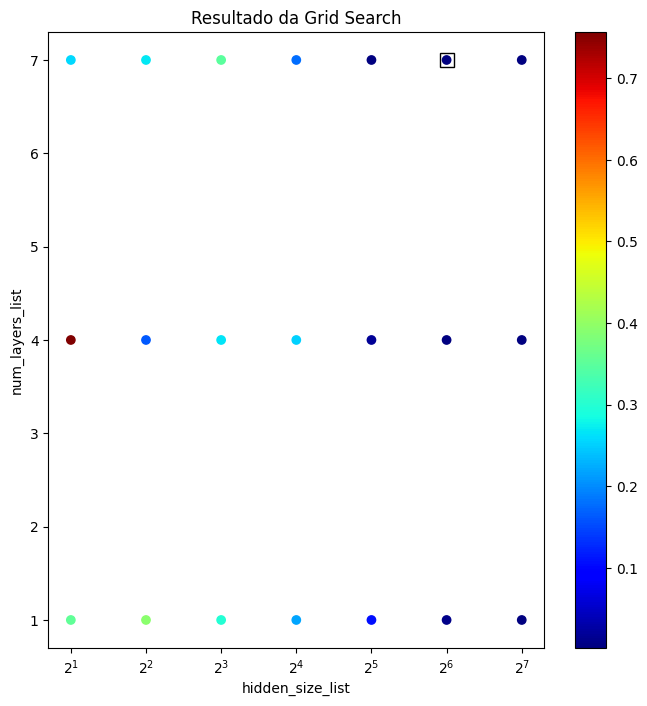

In [83]:
fig = plt.figure(figsize=(8, 8))

x_list = []
y_list = []
for hidden_size in hidden_size_list:
  for num_layers in num_layers_list:
    x_list.append(hidden_size)
    y_list.append(num_layers)


scatter = plt.scatter(x_list,
                      y_list,
                      c=rms_list, cmap='jet')

arr = np.array(rms_list)
idx_max = np.unravel_index(np.argmin(arr), arr.shape)

plt.plot(hidden_size_list[idx_max[0]],
        num_layers_list[idx_max[1]],
        'ks', mfc='none', markersize=10)

plt.title('Resultado da Grid Search')
plt.xlabel('hidden_size_list')
plt.xscale('log', base=2)
plt.ylabel('num_layers_list')
fig.colorbar(scatter)
plt.show()

Segunda Grade

In [84]:
hidden_size_list = np.arange(30, 150, 12)
num_layers_list = np.arange(2, 12, 3)

rms_list = []

for hidden_size in hidden_size_list:
  aux_list = []
  for num_layers in num_layers_list:
    print(f'Hidden Size {hidden_size} - Num Layer {num_layers}')
    model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=int(hidden_size), num_layers=num_layers)
    model_lstm.fit(train_loader, n_epochs=35, lr=0.00001, val_loader=val_loader, verbose=0)
    aux_list.append(model_lstm.history_val_loss[-1])
  rms_list.append(aux_list)

Hidden Size 30 - Num Layer 2
Hidden Size 30 - Num Layer 5
Hidden Size 30 - Num Layer 8
Hidden Size 30 - Num Layer 11
Hidden Size 42 - Num Layer 2
Hidden Size 42 - Num Layer 5
Hidden Size 42 - Num Layer 8
Hidden Size 42 - Num Layer 11
Hidden Size 54 - Num Layer 2
Hidden Size 54 - Num Layer 5
Hidden Size 54 - Num Layer 8
Hidden Size 54 - Num Layer 11
Hidden Size 66 - Num Layer 2
Hidden Size 66 - Num Layer 5
Hidden Size 66 - Num Layer 8
Hidden Size 66 - Num Layer 11
Hidden Size 78 - Num Layer 2
Hidden Size 78 - Num Layer 5
Hidden Size 78 - Num Layer 8
Hidden Size 78 - Num Layer 11
Hidden Size 90 - Num Layer 2
Hidden Size 90 - Num Layer 5
Hidden Size 90 - Num Layer 8
Hidden Size 90 - Num Layer 11
Hidden Size 102 - Num Layer 2
Hidden Size 102 - Num Layer 5
Hidden Size 102 - Num Layer 8
Hidden Size 102 - Num Layer 11
Hidden Size 114 - Num Layer 2
Hidden Size 114 - Num Layer 5
Hidden Size 114 - Num Layer 8
Hidden Size 114 - Num Layer 11
Hidden Size 126 - Num Layer 2
Hidden Size 126 - Num Laye

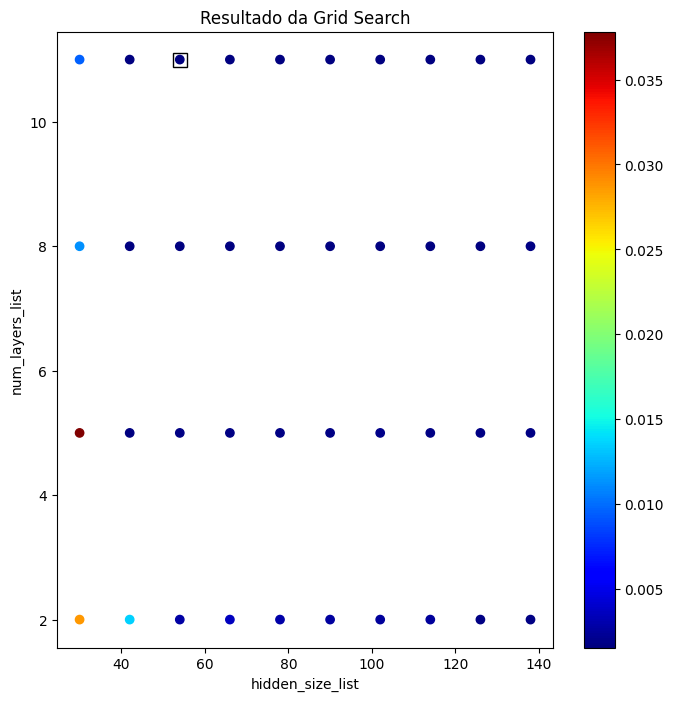

In [85]:
fig = plt.figure(figsize=(8, 8))

x_list = []
y_list = []
for hidden_size in hidden_size_list:
  for num_layers in num_layers_list:
    x_list.append(hidden_size)
    y_list.append(num_layers)


scatter = plt.scatter(x_list,
                      y_list,
                      c=rms_list, cmap='jet')

arr = np.array(rms_list)
idx_max = np.unravel_index(np.argmin(arr), arr.shape)

plt.plot(hidden_size_list[idx_max[0]],
        num_layers_list[idx_max[1]],
        'ks', mfc='none', markersize=10)

plt.title('Resultado da Grid Search')
plt.xlabel('hidden_size_list')
plt.ylabel('num_layers_list')
fig.colorbar(scatter)
plt.show()

Terceira Gried

In [86]:
hidden_size_list = np.arange(50, 65, 2)
num_layers_list = np.arange(5, 30, 5)

rms_list = []

for hidden_size in hidden_size_list:
  aux_list = []
  for num_layers in num_layers_list:
    print(f'Hidden Size {hidden_size} - Num Layer {num_layers}')
    model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=int(hidden_size), num_layers=num_layers)
    model_lstm.fit(train_loader, n_epochs=35, lr=0.00001, val_loader=val_loader, verbose=0)
    aux_list.append(model_lstm.history_val_loss[-1])
  rms_list.append(aux_list)

Hidden Size 50 - Num Layer 5
Hidden Size 50 - Num Layer 10
Hidden Size 50 - Num Layer 15
Hidden Size 50 - Num Layer 20
Hidden Size 50 - Num Layer 25
Hidden Size 52 - Num Layer 5
Hidden Size 52 - Num Layer 10
Hidden Size 52 - Num Layer 15
Hidden Size 52 - Num Layer 20
Hidden Size 52 - Num Layer 25
Hidden Size 54 - Num Layer 5
Hidden Size 54 - Num Layer 10
Hidden Size 54 - Num Layer 15
Hidden Size 54 - Num Layer 20
Hidden Size 54 - Num Layer 25
Hidden Size 56 - Num Layer 5
Hidden Size 56 - Num Layer 10
Hidden Size 56 - Num Layer 15
Hidden Size 56 - Num Layer 20
Hidden Size 56 - Num Layer 25
Hidden Size 58 - Num Layer 5
Hidden Size 58 - Num Layer 10
Hidden Size 58 - Num Layer 15
Hidden Size 58 - Num Layer 20
Hidden Size 58 - Num Layer 25
Hidden Size 60 - Num Layer 5
Hidden Size 60 - Num Layer 10
Hidden Size 60 - Num Layer 15
Hidden Size 60 - Num Layer 20
Hidden Size 60 - Num Layer 25
Hidden Size 62 - Num Layer 5
Hidden Size 62 - Num Layer 10
Hidden Size 62 - Num Layer 15
Hidden Size 62 - 

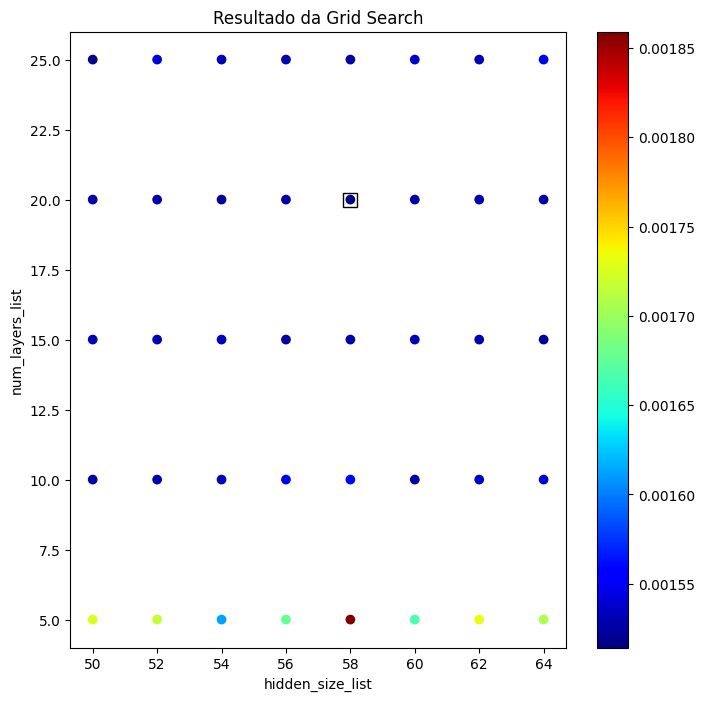

In [87]:
fig = plt.figure(figsize=(8, 8))

x_list = []
y_list = []
for hidden_size in hidden_size_list:
  for num_layers in num_layers_list:
    x_list.append(hidden_size)
    y_list.append(num_layers)


scatter = plt.scatter(x_list,
                      y_list,
                      c=rms_list, cmap='jet')

arr = np.array(rms_list)
idx_max = np.unravel_index(np.argmin(arr), arr.shape)

plt.plot(hidden_size_list[idx_max[0]],
        num_layers_list[idx_max[1]],
        'ks', mfc='none', markersize=10)

plt.title('Resultado da Grid Search')
plt.xlabel('hidden_size_list')
plt.ylabel('num_layers_list')
fig.colorbar(scatter)
plt.show()

### Chamada da Função

In [93]:
model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=58, num_layers=20)
model_lstm.fit(train_loader, n_epochs=100, lr=0.00001, val_loader=val_loader)

Epoch 1/100, Loss: 0.004709, Train: 0.317566, Val: 0.321076
Epoch 2/100, Loss: 0.004613, Train: 0.281035, Val: 0.314651
Epoch 3/100, Loss: 0.004516, Train: 0.273467, Val: 0.308117
Epoch 4/100, Loss: 0.004418, Train: 0.300642, Val: 0.301342
Epoch 5/100, Loss: 0.004313, Train: 0.277763, Val: 0.294152
Epoch 6/100, Loss: 0.004202, Train: 0.255869, Val: 0.286281
Epoch 7/100, Loss: 0.004077, Train: 0.255249, Val: 0.277324
Epoch 8/100, Loss: 0.003931, Train: 0.254557, Val: 0.266577
Epoch 9/100, Loss: 0.003750, Train: 0.243894, Val: 0.252509
Epoch 10/100, Loss: 0.003493, Train: 0.223716, Val: 0.230762
Epoch 11/100, Loss: 0.003039, Train: 0.167178, Val: 0.187483
Epoch 12/100, Loss: 0.002159, Train: 0.105321, Val: 0.115174
Epoch 13/100, Loss: 0.001155, Train: 0.051077, Val: 0.058201
Epoch 14/100, Loss: 0.000548, Train: 0.019915, Val: 0.029755
Epoch 15/100, Loss: 0.000282, Train: 0.023676, Val: 0.016614
Epoch 16/100, Loss: 0.000162, Train: 0.008873, Val: 0.009694
Epoch 17/100, Loss: 0.000101, Tra

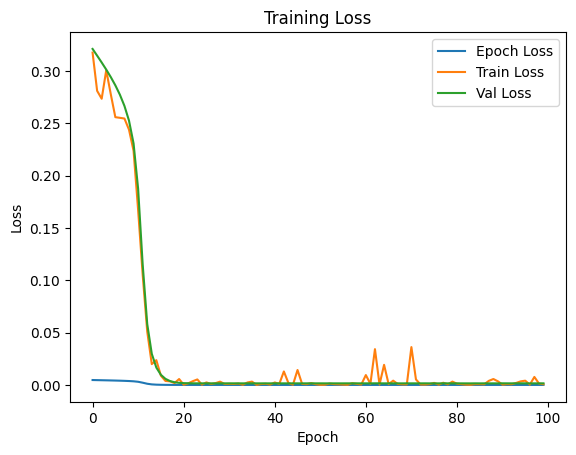

In [94]:
plt.plot(model_lstm.history_epoch_loss, label='Epoch Loss')
plt.plot(model_lstm.history_train_loss, label='Train Loss')
plt.plot(model_lstm.history_val_loss, label='Val Loss')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Chamada final

In [95]:
model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=58, num_layers=20)
model_lstm.fit(train_loader, n_epochs=30, lr=0.00001, val_loader=val_loader)

Epoch 1/30, Loss: 0.004384, Train: 0.272335, Val: 0.296386
Epoch 2/30, Loss: 0.004303, Train: 0.273627, Val: 0.291014
Epoch 3/30, Loss: 0.004221, Train: 0.243328, Val: 0.285584
Epoch 4/30, Loss: 0.004138, Train: 0.266745, Val: 0.279960
Epoch 5/30, Loss: 0.004051, Train: 0.261063, Val: 0.273984
Epoch 6/30, Loss: 0.003957, Train: 0.236682, Val: 0.267436
Epoch 7/30, Loss: 0.003853, Train: 0.245811, Val: 0.259936
Epoch 8/30, Loss: 0.003729, Train: 0.241362, Val: 0.250717
Epoch 9/30, Loss: 0.003568, Train: 0.221781, Val: 0.237897
Epoch 10/30, Loss: 0.003319, Train: 0.196934, Val: 0.215401
Epoch 11/30, Loss: 0.002810, Train: 0.139986, Val: 0.165113
Epoch 12/30, Loss: 0.001883, Train: 0.099447, Val: 0.097932
Epoch 13/30, Loss: 0.001064, Train: 0.049340, Val: 0.055380
Epoch 14/30, Loss: 0.000606, Train: 0.031945, Val: 0.032630
Epoch 15/30, Loss: 0.000362, Train: 0.016738, Val: 0.020039
Epoch 16/30, Loss: 0.000226, Train: 0.011676, Val: 0.012747
Epoch 17/30, Loss: 0.000147, Train: 0.010079, Val

In [99]:
len(test_ds)

986

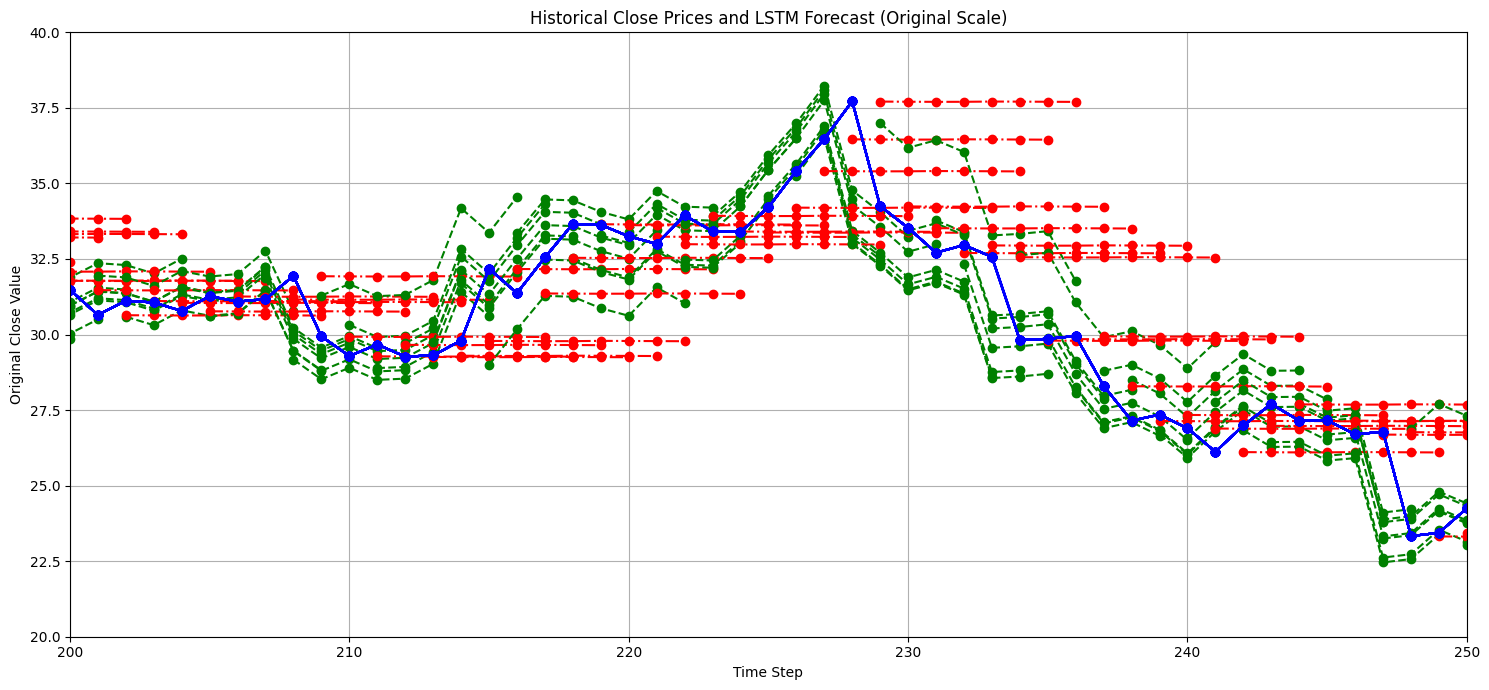

In [110]:
plt.figure(figsize=(15, 7))

for i in range(len(test_ds)):

  history_features, decoder_inputs, future_targets = test_ds[i]

  prediction = model_lstm.predict(history_features.unsqueeze(0))

  # --- Inverse Scaling for Close history, Predictions (diff) and Future Targets (diff) ---

  # Get the total number of features the scaler was fitted on (Close, High, Low, Open, Volume, y)
  n_features_total = len(df.columns) # This is 6
  n_features_X = len(columns_features) # This is 5

  # 1. Inverse scale the 'Close' values from history_features (index 0 of features)
  scaled_history_close = history_features[:, 0].numpy() # Extract scaled 'Close' column
  dummy_array_history_close = np.zeros((T_X, n_features_total), dtype=np.float32)
  dummy_array_history_close[:, 0] = scaled_history_close # Place scaled 'Close' in the first column
  original_history_close = scaler.inverse_transform(dummy_array_history_close)[:, 0]

  # 2. Inverse scale the prediction (which are scaled 'y' differences)
  dummy_array_pred_diff = np.zeros((T_Y, n_features_total), dtype=np.float32)
  dummy_array_pred_diff[:, -1] = prediction.flatten() # Place scaled predictions in the 'y' column (last)
  original_prediction_diff = scaler.inverse_transform(dummy_array_pred_diff)[:, -1]

  # 3. Inverse scale the future targets (which are scaled 'y' differences)
  future_targets_np = future_targets.numpy().flatten()
  dummy_array_targets_diff = np.zeros((T_Y, n_features_total), dtype=np.float32)
  dummy_array_targets_diff[:, -1] = future_targets_np # Place scaled targets in the 'y' column
  original_future_targets_diff = scaler.inverse_transform(dummy_array_targets_diff)[:, -1]


  last_historical_close = original_history_close[-1]
  cumulative_prediction_prices = np.cumsum(original_prediction_diff) + last_historical_close
  cumulative_future_prices = np.cumsum(original_future_targets_diff) + last_historical_close



  plt.plot(np.arange(i, T_X + i), original_history_close, label='Historical Close (Original Scale)', color='blue', marker='o')
  plt.plot(np.arange(T_X + i, T_X + T_Y + i), cumulative_future_prices, label='Actual Future Close (Original Scale)', color='green', linestyle='--', marker='o')
  plt.plot(np.arange(T_X + i, T_X + T_Y + i), cumulative_prediction_prices, label='LSTM Predicted Close (Original Scale)', color='red', linestyle='-.', marker='o')

plt.title('Historical Close Prices and LSTM Forecast (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Original Close Value')
#plt.legend()
plt.axis([200, 250, 20, 40])
plt.grid(True)
#plt.axvline(x=T_X-1, color='gray', linestyle=':', linewidth=1, label='Forecast Start')
plt.tight_layout()
plt.show()